# IMAGE PROCESSING

## Library yang diperlukan

In [43]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import bm3d
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio
from layeris.layer_image import LayerImage
%matplotlib inline

### Load Data 

In [44]:
root_path_testing = 'Before/*.jpg' # merupakan tempat gambar yang akan di blend 
root_path_saving = 'After/' # merupakan tempat gambar yang akan di save 
file_path = glob.glob(root_path_testing)

# Contoh Kasus
## Proses Penghilangan Noise Dari Citra Bakteri Yang Dilihat Dengan Menggunakan Mikroskop

Sebelum Denoising
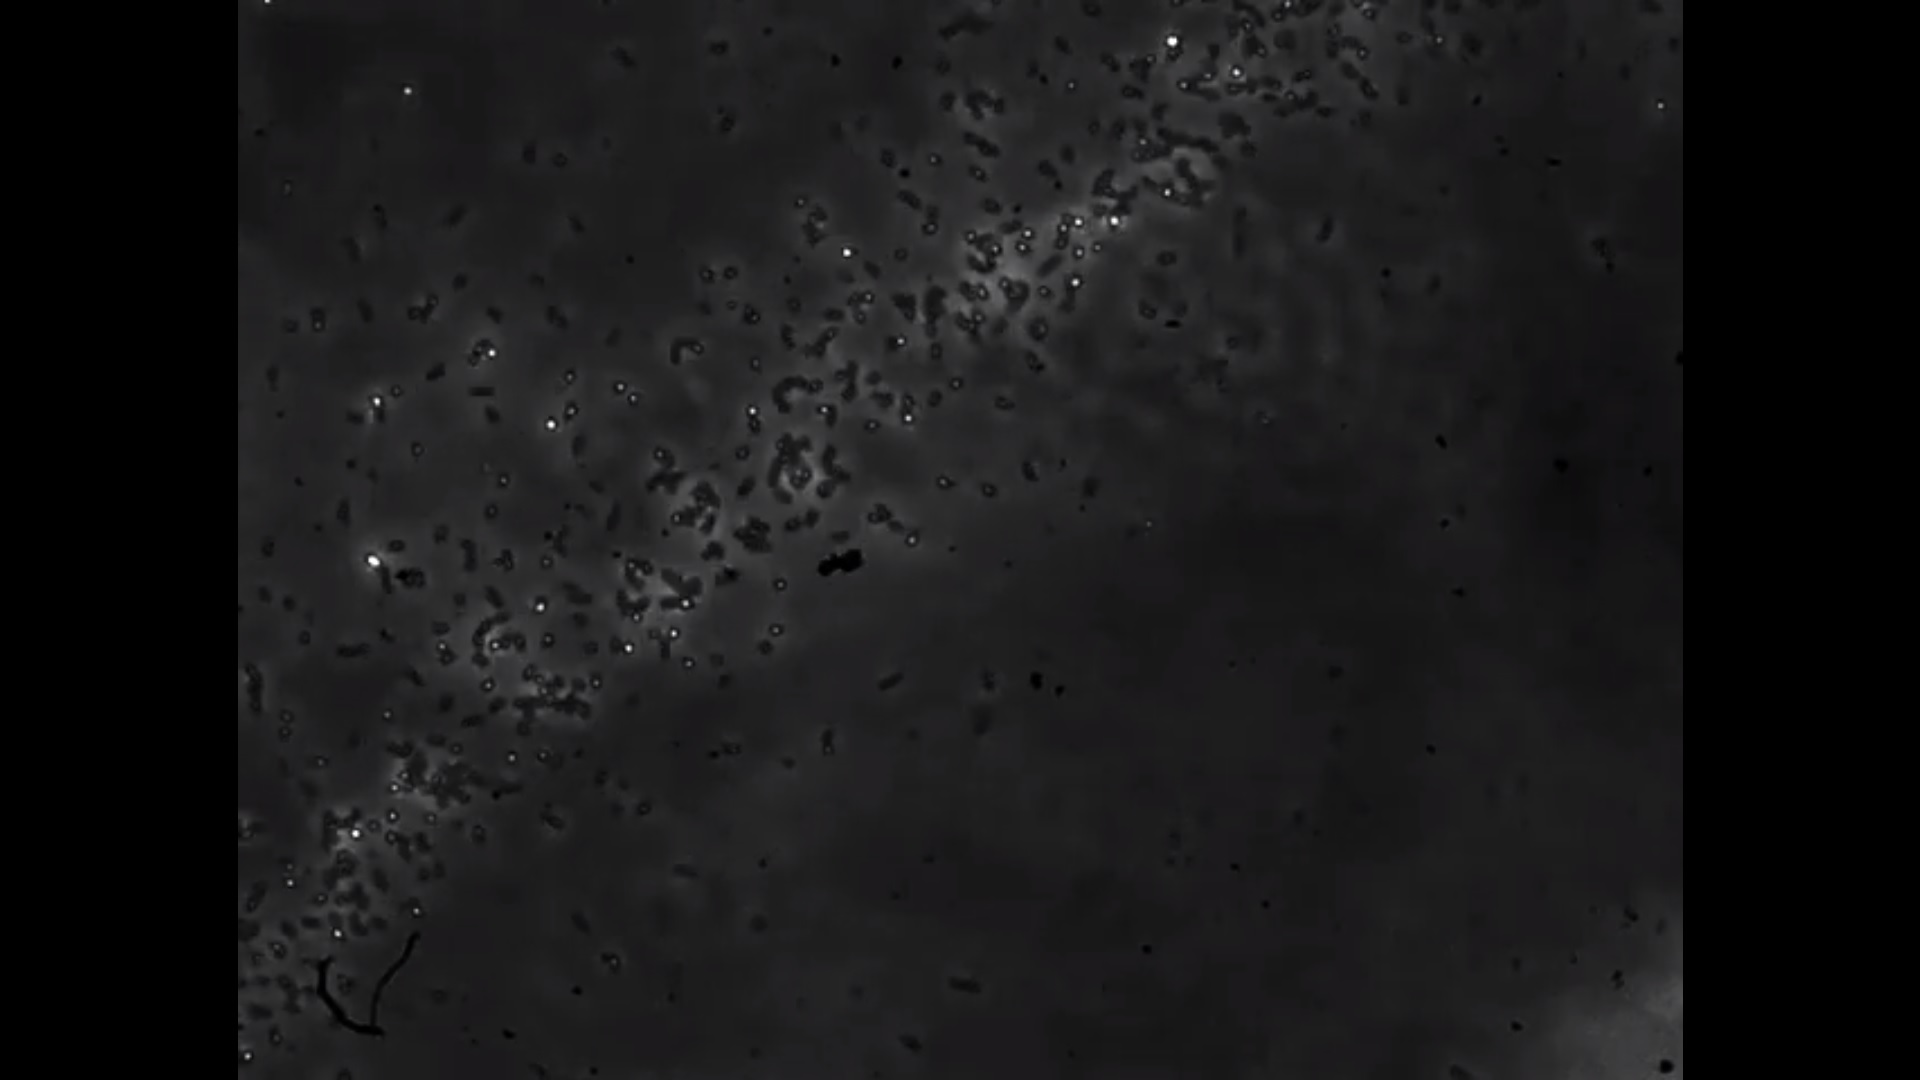              

#### Fixed Thresholding

In [45]:
for path in file_path:
    img=cv2.imread(path)
    th,img_th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    filename = path.split('\\')[-1]
    cv2.imwrite(root_path_saving + filename,img_th1)

Hasil Fixed Thresholding
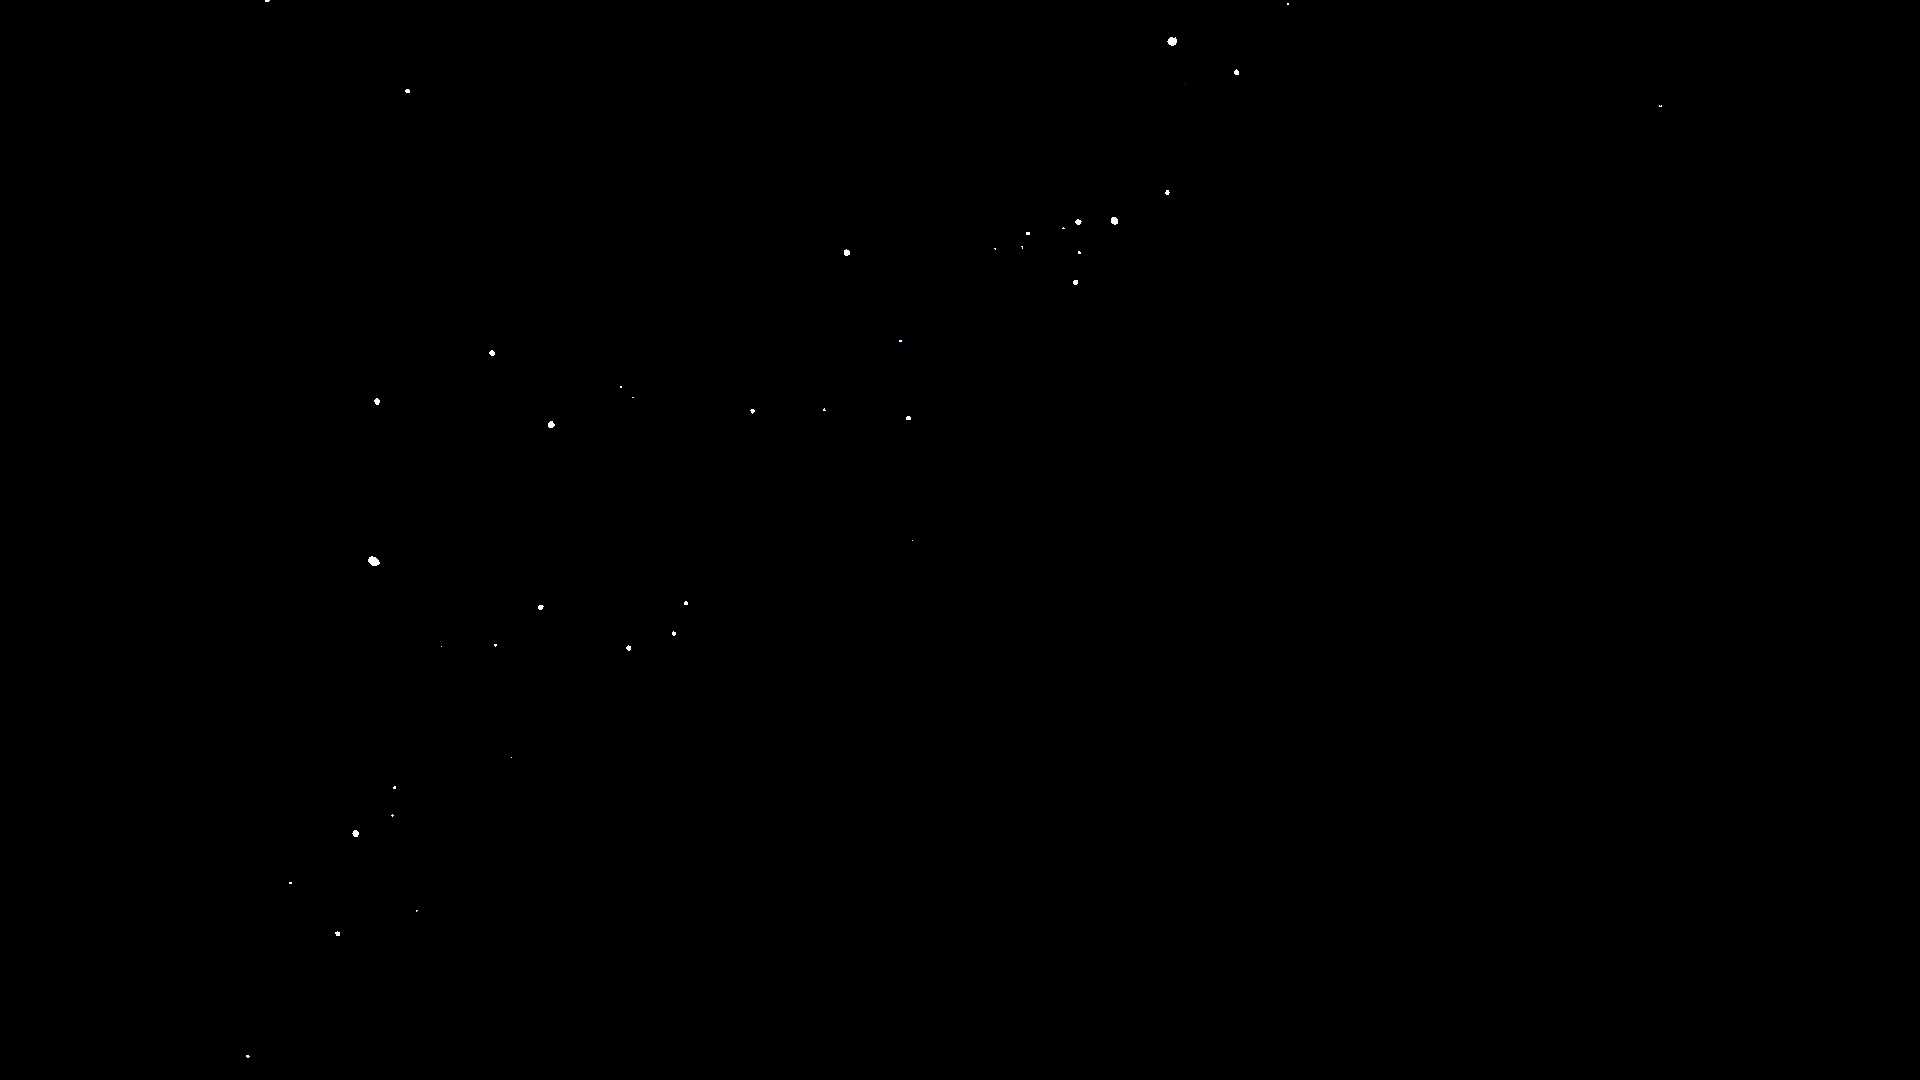

#### Denoising filter 2D 

In [46]:
for path in file_path:
    img = cv2.imread(path)
    kernel = np.ones((3,3), np.float32)/9
    filt_2D = cv2.filter2D(img, -1, kernel)
    
    filename = path.split('\\')[-1]
    cv2.imwrite(root_path_saving + filename,filt_2D)

Hasil Denoising FIlter 2D
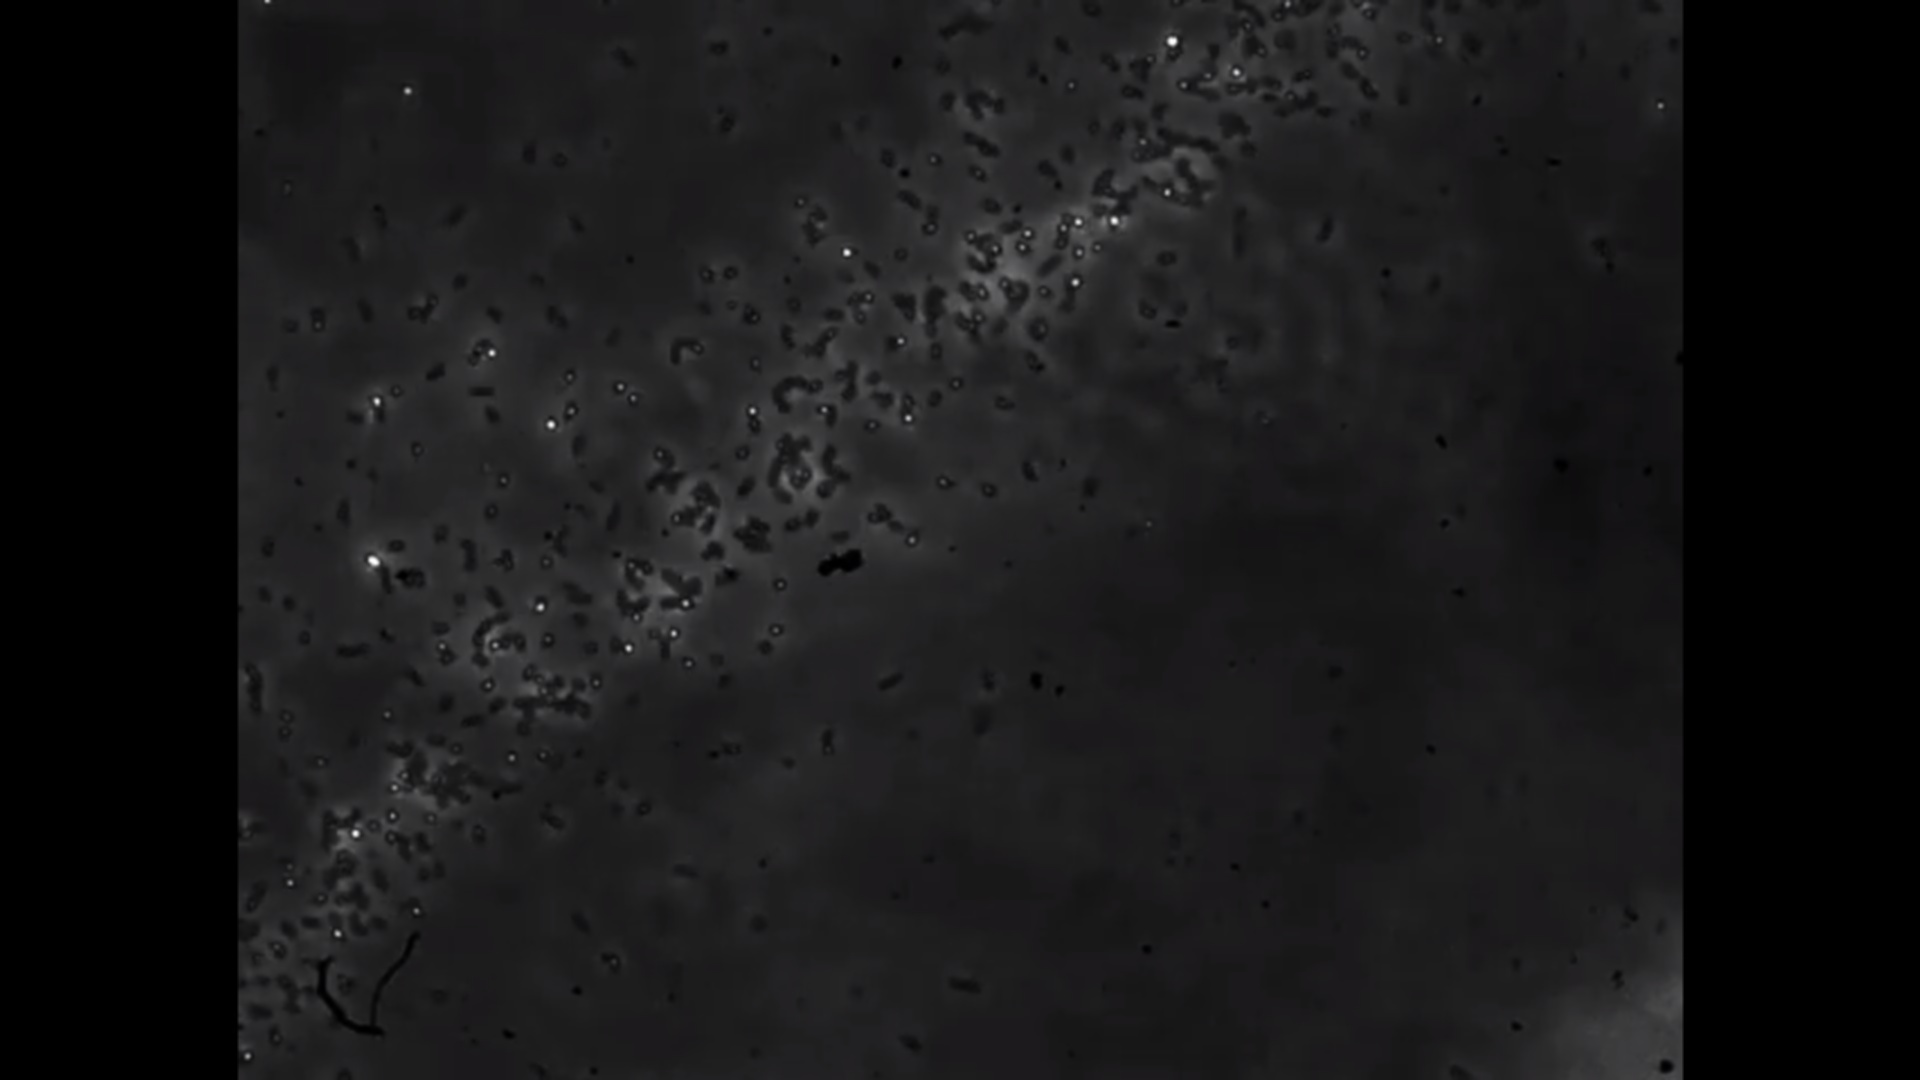

#### Denoising Blur 

In [48]:
for path in file_path:
    img = cv2.imread(path)
    kernel = np.ones((3,3), np.float32)/9
    blur = cv2.blur(img, (3,3))
    
    # split filename
    filename = path.split('\\')[-1]
    cv2.imwrite(root_path_saving + filename, blur)

Hasil Denoising Blur
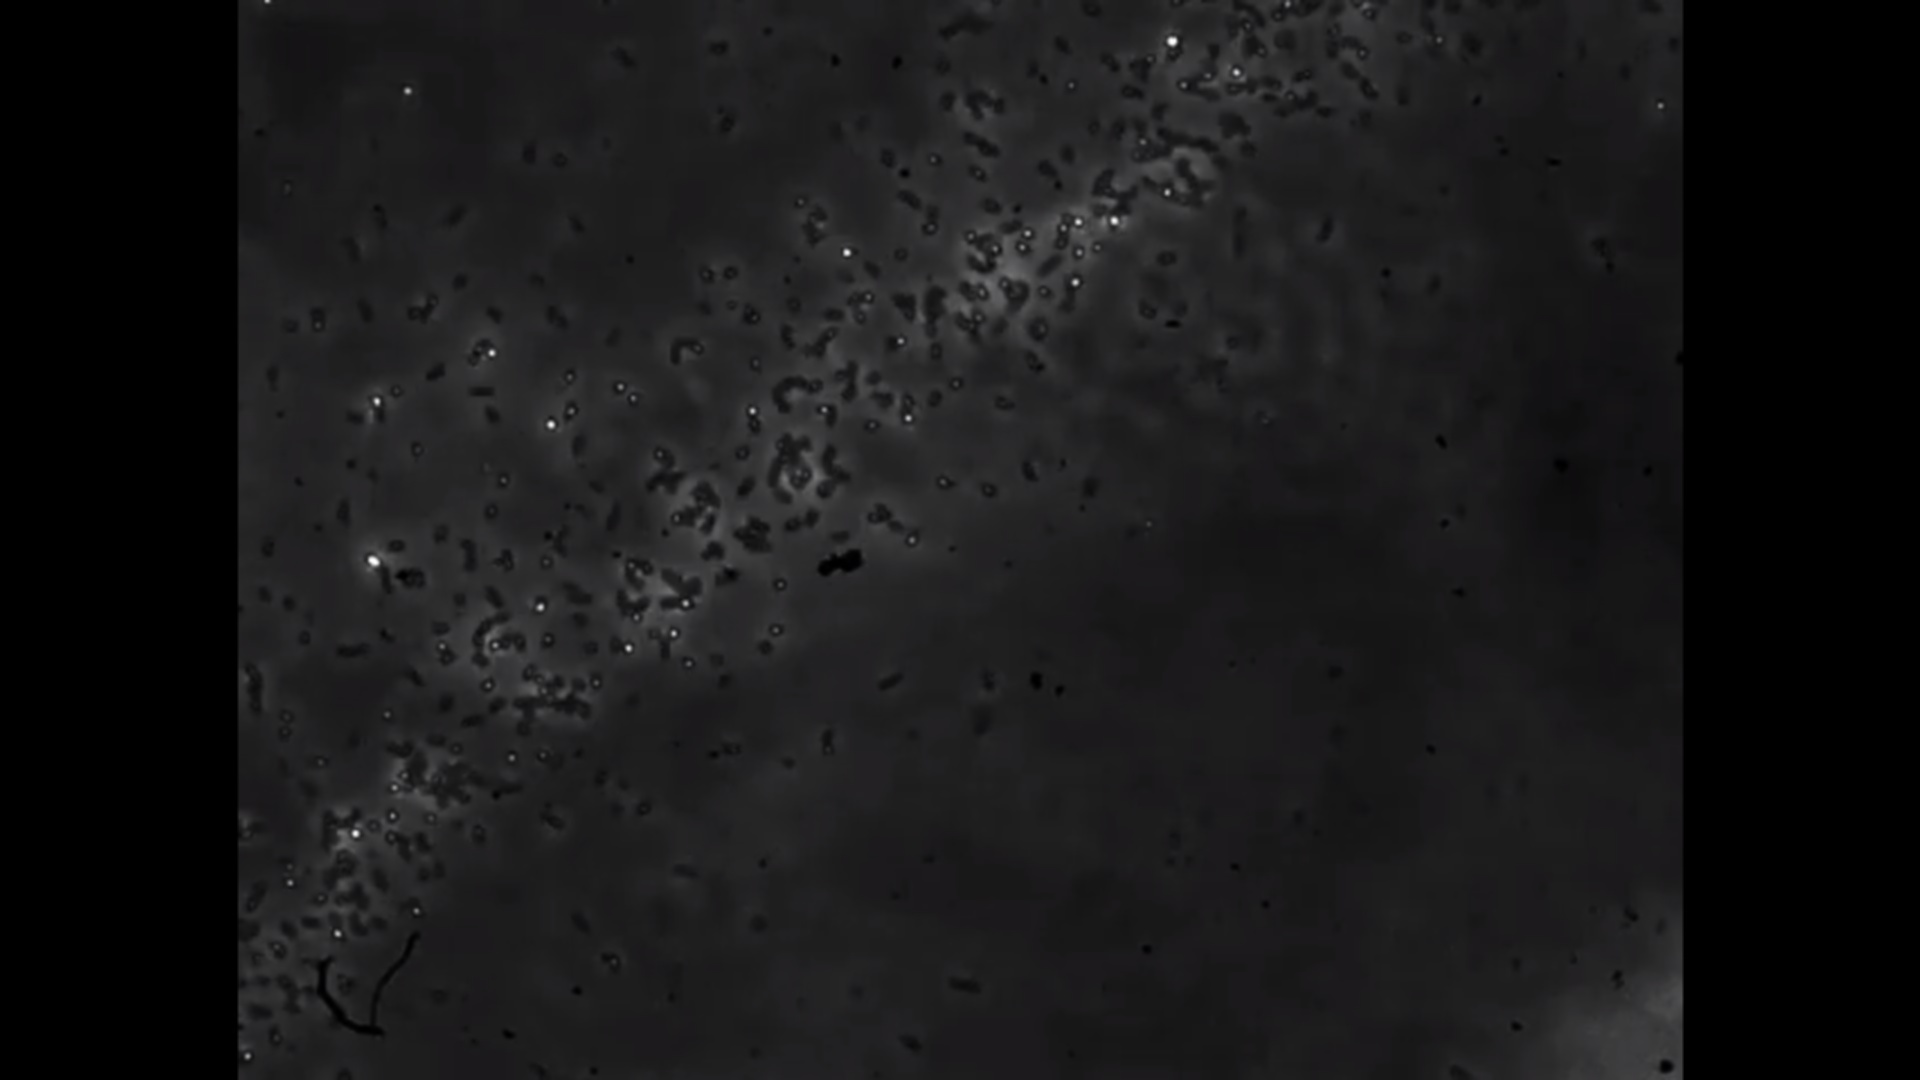

#### CLAHE

In [49]:
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
for path in file_path:
    image = cv2.imread(path, 0)
    image_equ = clahe.apply(image)
    
    # Split filename
    filename = path.split('\\')[-1]
    cv2.imwrite(root_path_saving + filename, image_equ)

Hasil Clahe
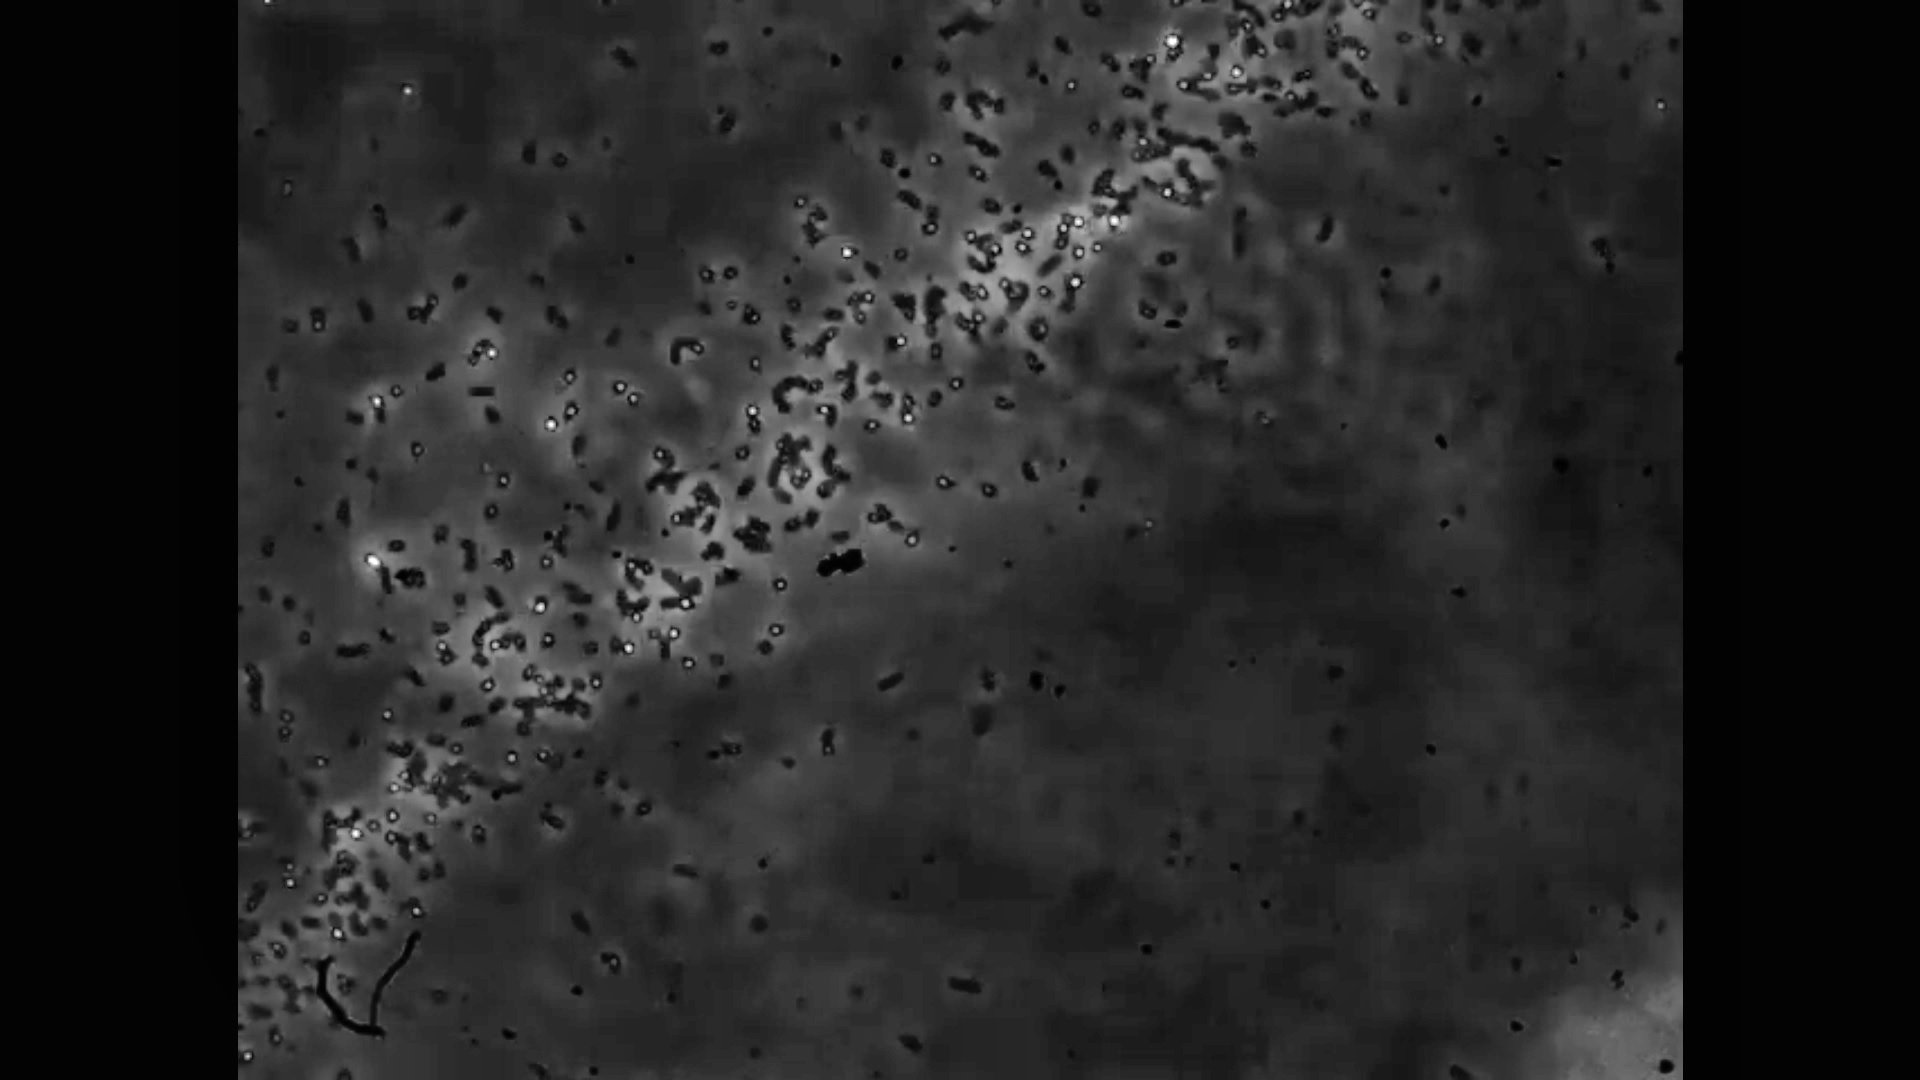

#### Histogram Equalization

In [54]:
for path in file_path:
    img = cv2.imread(path,0) # grayscale
    equ = cv2.equalizeHist(img)
    
    # save
    filename = path.split('\\')[-1]
    cv2.imwrite(root_path_saving + filename, equ)

Hasil Histogram Equalization
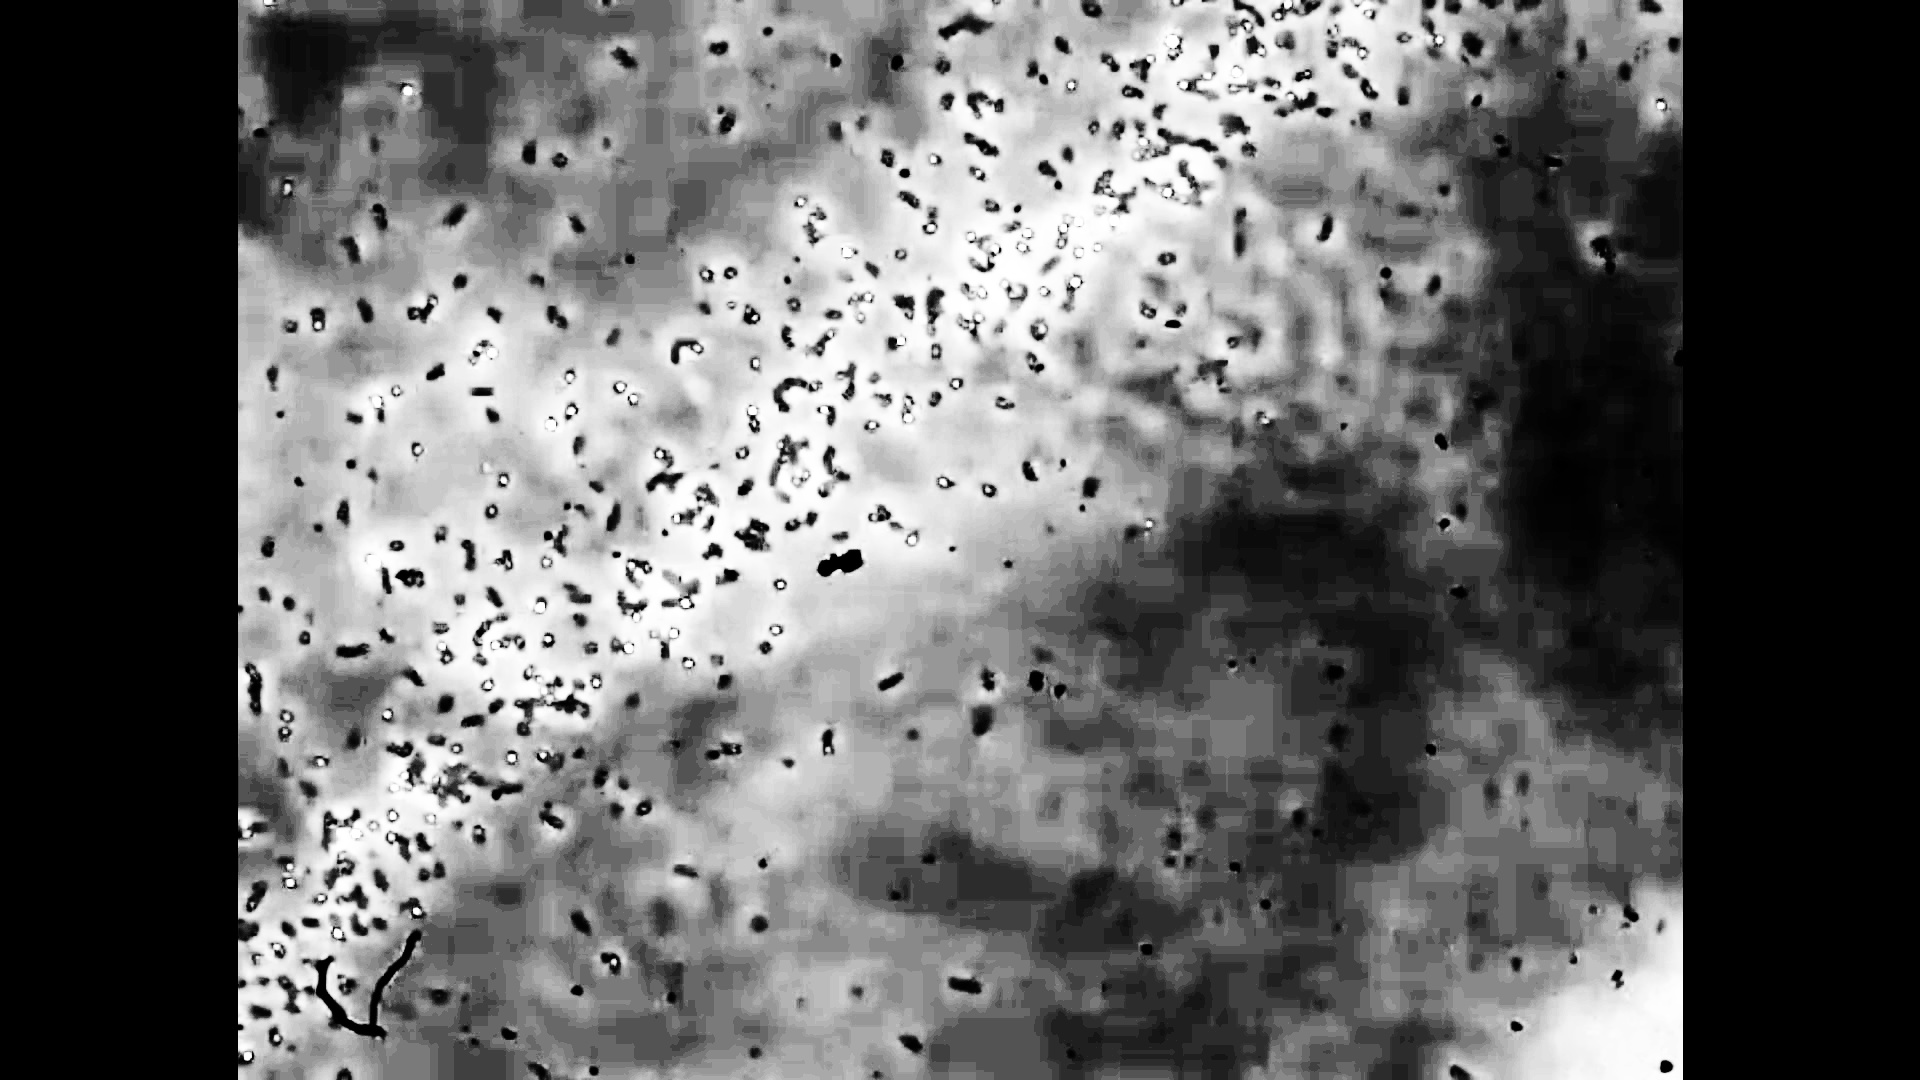

#### Block & Matching 3D

In [51]:
for path in file_path:
    img = img_as_float(io.imread(path,as_gray= True))
    BM3D_denoised_image = bm3d.bm3d(img, sigma_psd=0.2, stage_arg = bm3d.BM3DStages.ALL_STAGES)
    # BM#D_denoised_image = bm3d.bm3d(img, sigma_psd=.2, storage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    
    filename = path.split('\\')[-1]
    plt.imsave(root_path_saving + filename, BM3D_denoised_image, cmap='gray')

Hasil BM3D
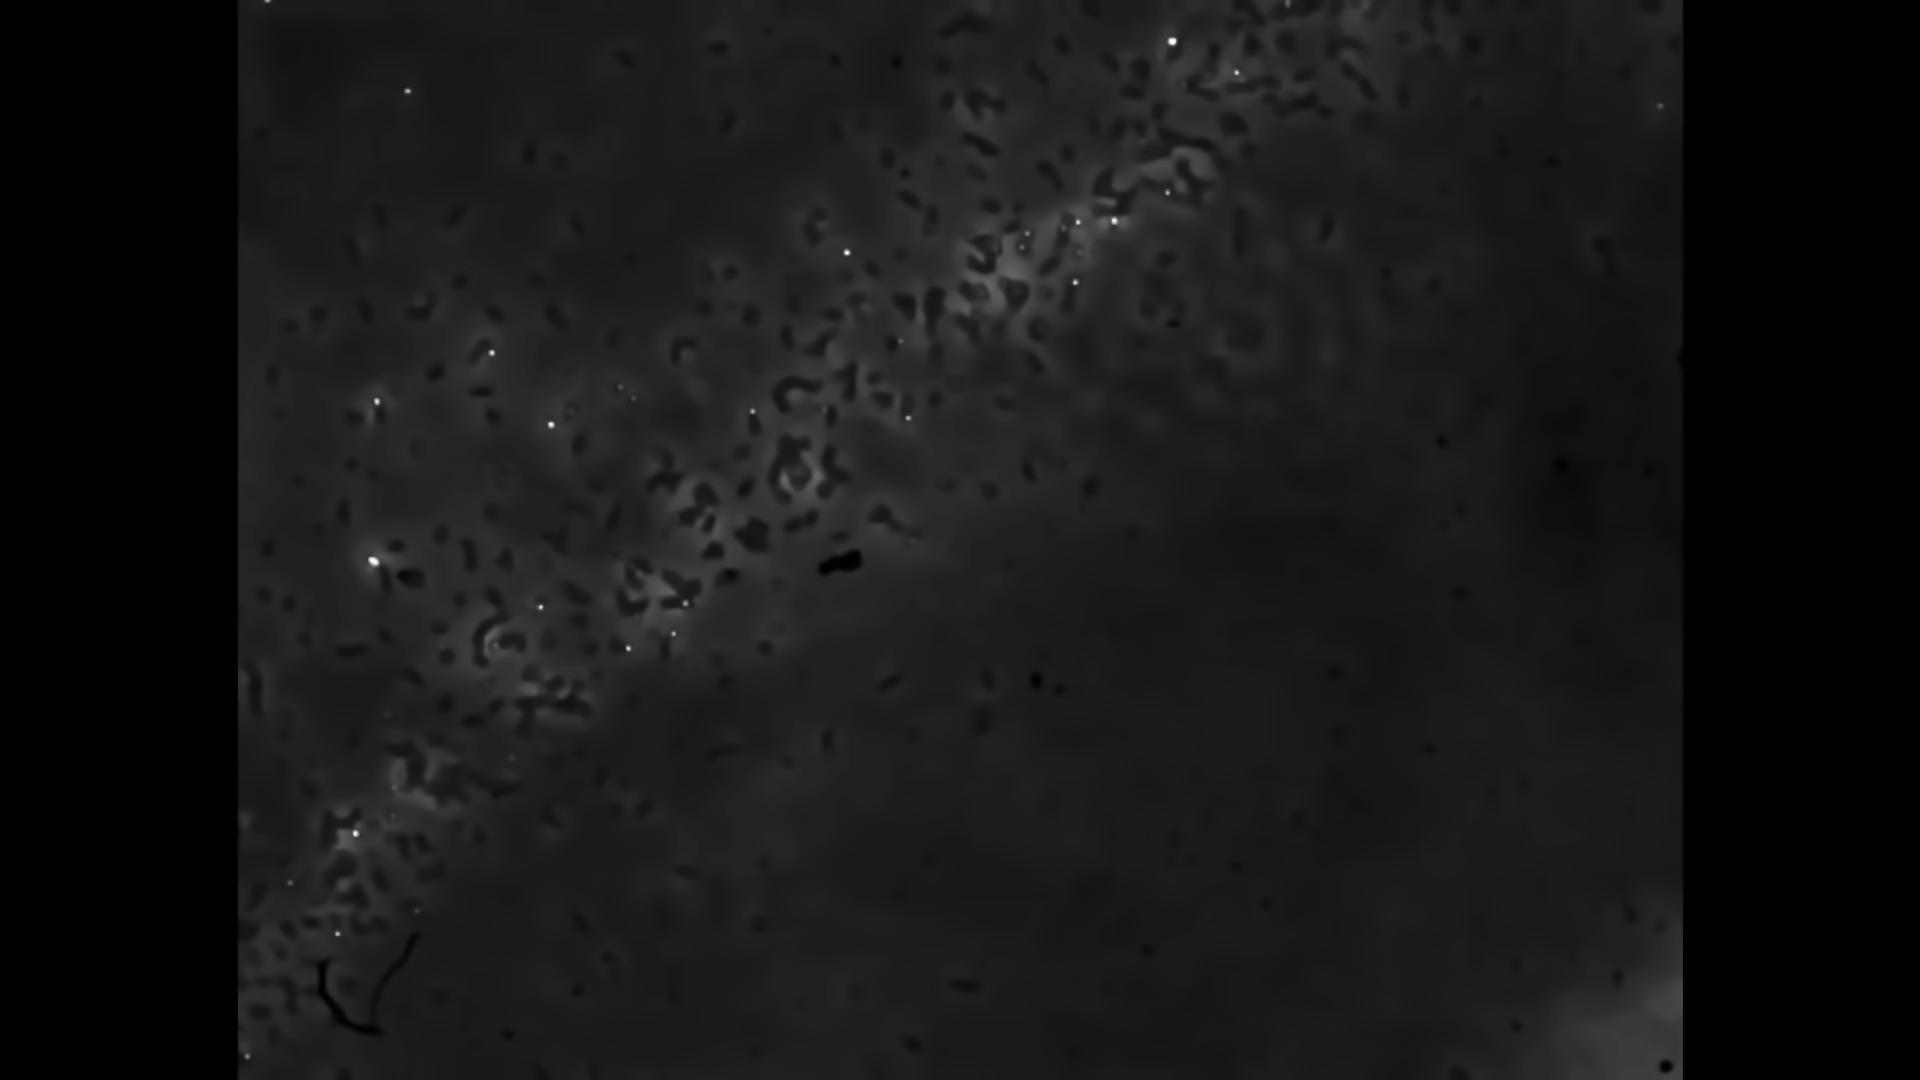

#### Segmentasi

In [57]:
#segmentation (Mengambil yang mana foreground yang mana background)
for path in file_path:
    gambar = cv2.imread(path)
gambar_gray = cv2.cvtColor(gambar, cv2.COLOR_BGR2GRAY)
th, img_th2 = cv2.threshold(gambar_gray, 0, 255, cv2.THRESH_OTSU)
ret, result = cv2.connectedComponents(img_th2)
idx = 0
background = np.zeros(img_th2.shape, np.uint8)
for res in np.unique(result):
    if res == 0:
        continue
    temp_obj = np.zeros(img_th2.shape, np.uint8)
    temp_obj[result ==res] = 255
   
    background = cv2.add(background, temp_obj)
    
conturs, hierarchy = cv2.findContours(background, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for idx_contur in conturs:
    x, y, w, h, = cv2.boundingRect(idx_contur)
    start = (x, y)
    end = (x + w, y + h)
    imgg = cv2.rectangle(img_th2, start, end, (255,0,0), 2)

    filename = path.split("\\")[-1]
    cv2.imwrite(root_path_saving + filename, imgg)

Hasil Segmentasi
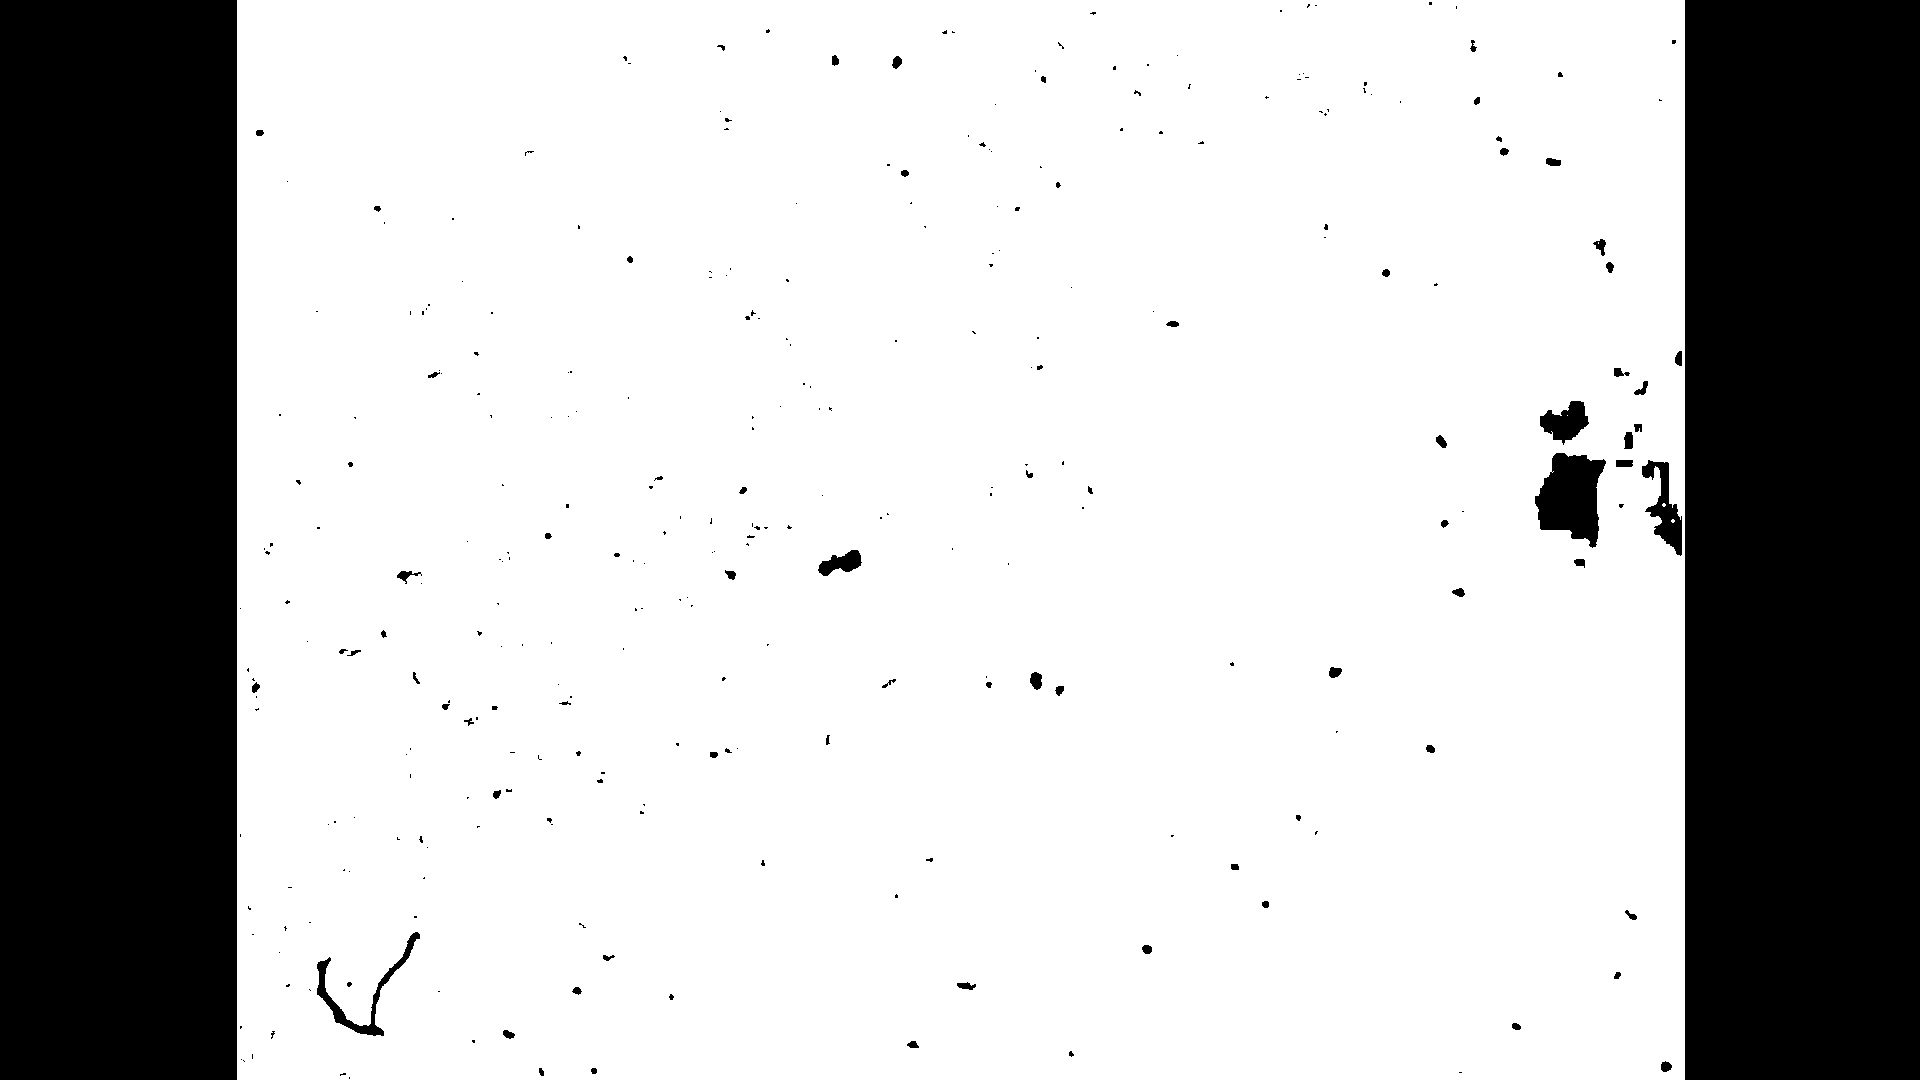

## Split Data

In [58]:
from sklearn.model_selection import train_test_split
import glob
import numpy as np
import os
import shutil

data_type = "sebelum split"
idx = 0

root_folder_image = "image/*.jpg".format(data_type, idx)
root_folder_label = "label/*.jpg".format(data_type, idx)

image = glob.glob(root_folder_image)
label = glob.glob(root_folder_label)

image = np.array(image)
label = np.array(label)

index_image = np.arange(len(image))
index_label = np.arange(len(label))

idx_image_train, idx_image_test, _, _ = train_test_split(index_image, index_image, test_size = 0.2, random_state = 32)

image_train = image[idx_image_train]
image_test = image[idx_image_test]

filenames = glob.glob("label/*.jpg")

# Root path yang digunakan
root_path_saving_train_image = 'train split/image' # Tempat gambar yang akan di save
root_path_saving_test_image = 'test split/image' # Tempat gambar yang akan di save
root_path_saving_train_label = 'train split/label' # Tempat gambar yang akan di save
root_path_saving_test_label = 'test split/label' # Tempat gambar yang akan di save

# Make new directory
os.makedirs(root_path_saving_train_image, exist_ok = True)
os.makedirs(root_path_saving_test_image, exist_ok = True)
os.makedirs(root_path_saving_train_label, exist_ok = True)
os.makedirs(root_path_saving_test_label, exist_ok = True)

path_test = "label/"
for i in range(len(image)):
    for j in range(len(image_train)):
        if(image[i] == image_train[j]):
            filename_train = image[i].split('\\')[-1]
            shutil.copy2(path_test + filename_train, root_path_saving_train_label.format(filename_train))

for idx, path in enumerate(image_test):
    filename = path.split('\\')[-1]
    shutil.copy2(path, root_path_saving_test_image.format(filename))
    
path_test = "label/"
for i in range(len(image)):
    for j in range(len(image_test)):
        if(image[i] == image_test[j]):
            filename_train = image[i].split('\\')[-1]
            shutil.copy2(path_test + filename_train, root_path_saving_test_label.format(filename_train))

Salah Satu Hasil Train Split Image : Tidak ada

Salah Satu Hasil Train Split Label :
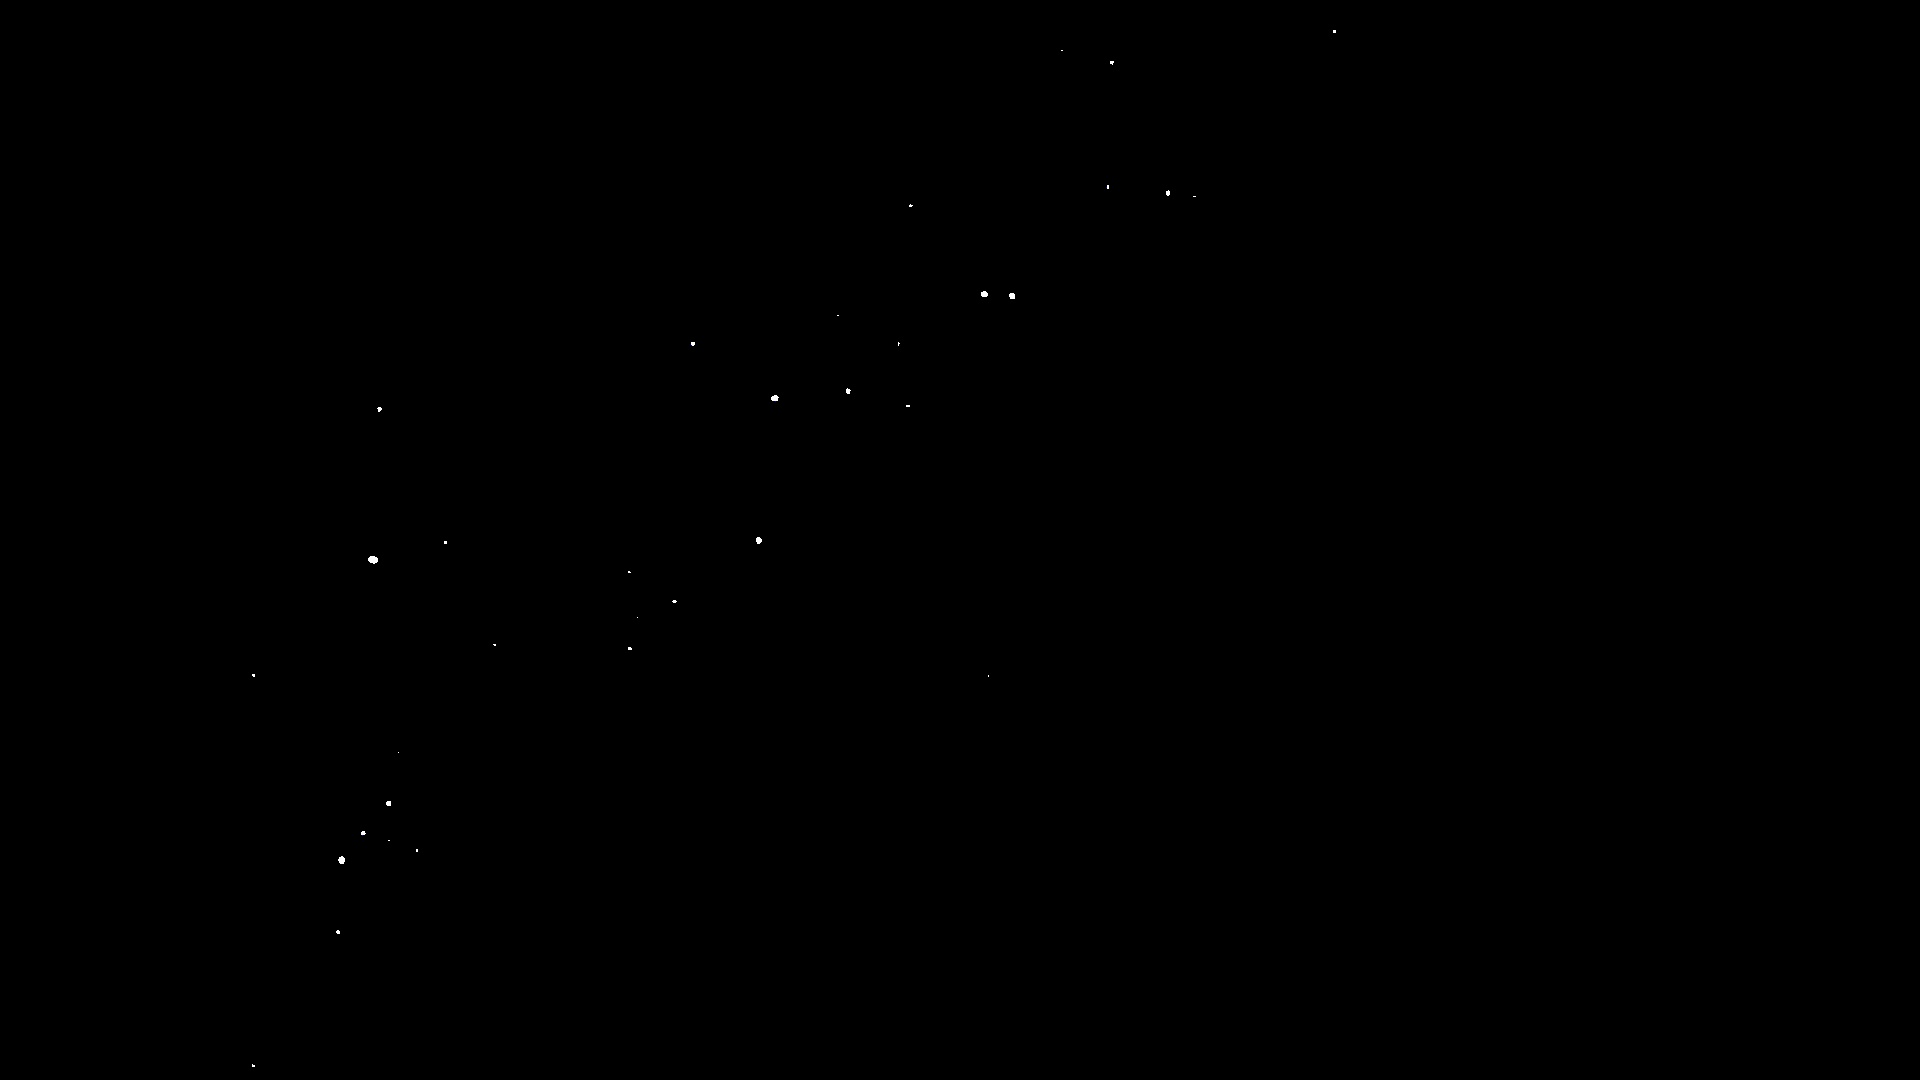

Salah Satu Hasil Test Split Image :
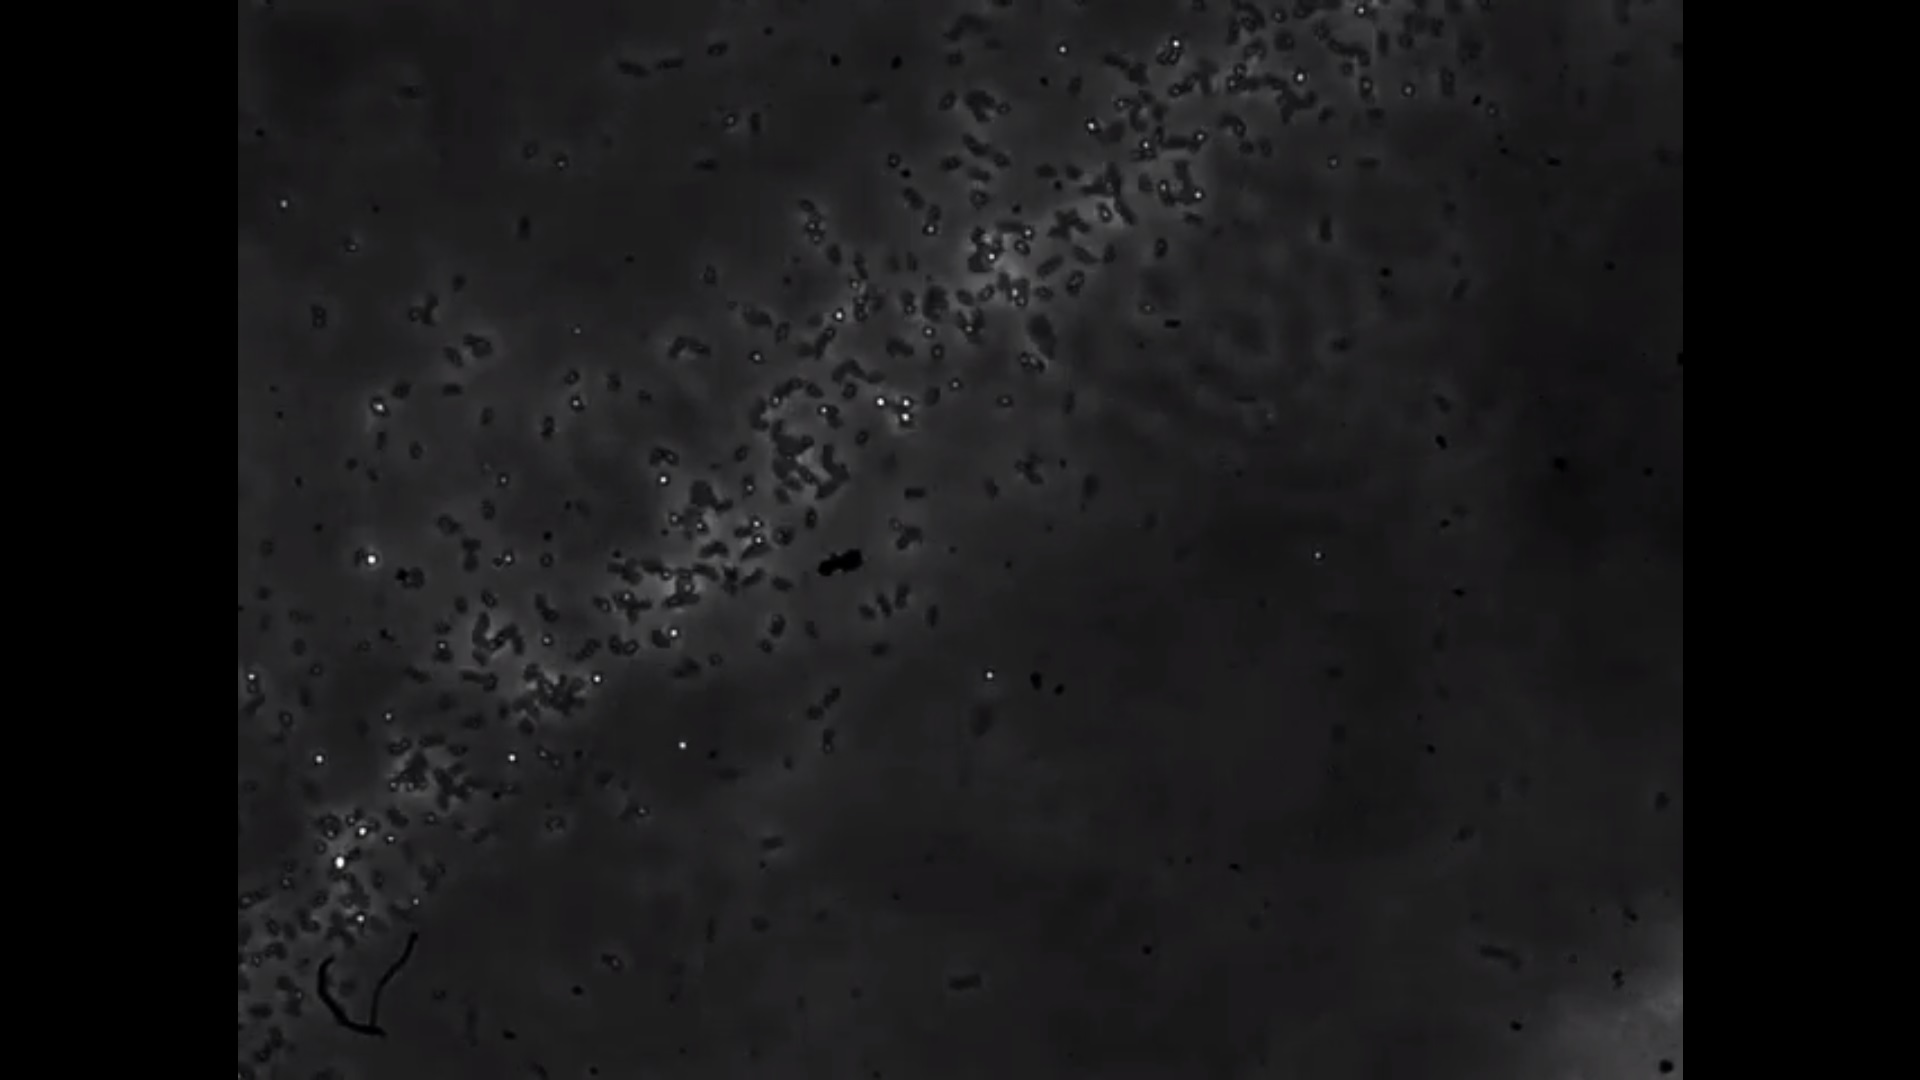

Salah Satu Hasil Test Split label :
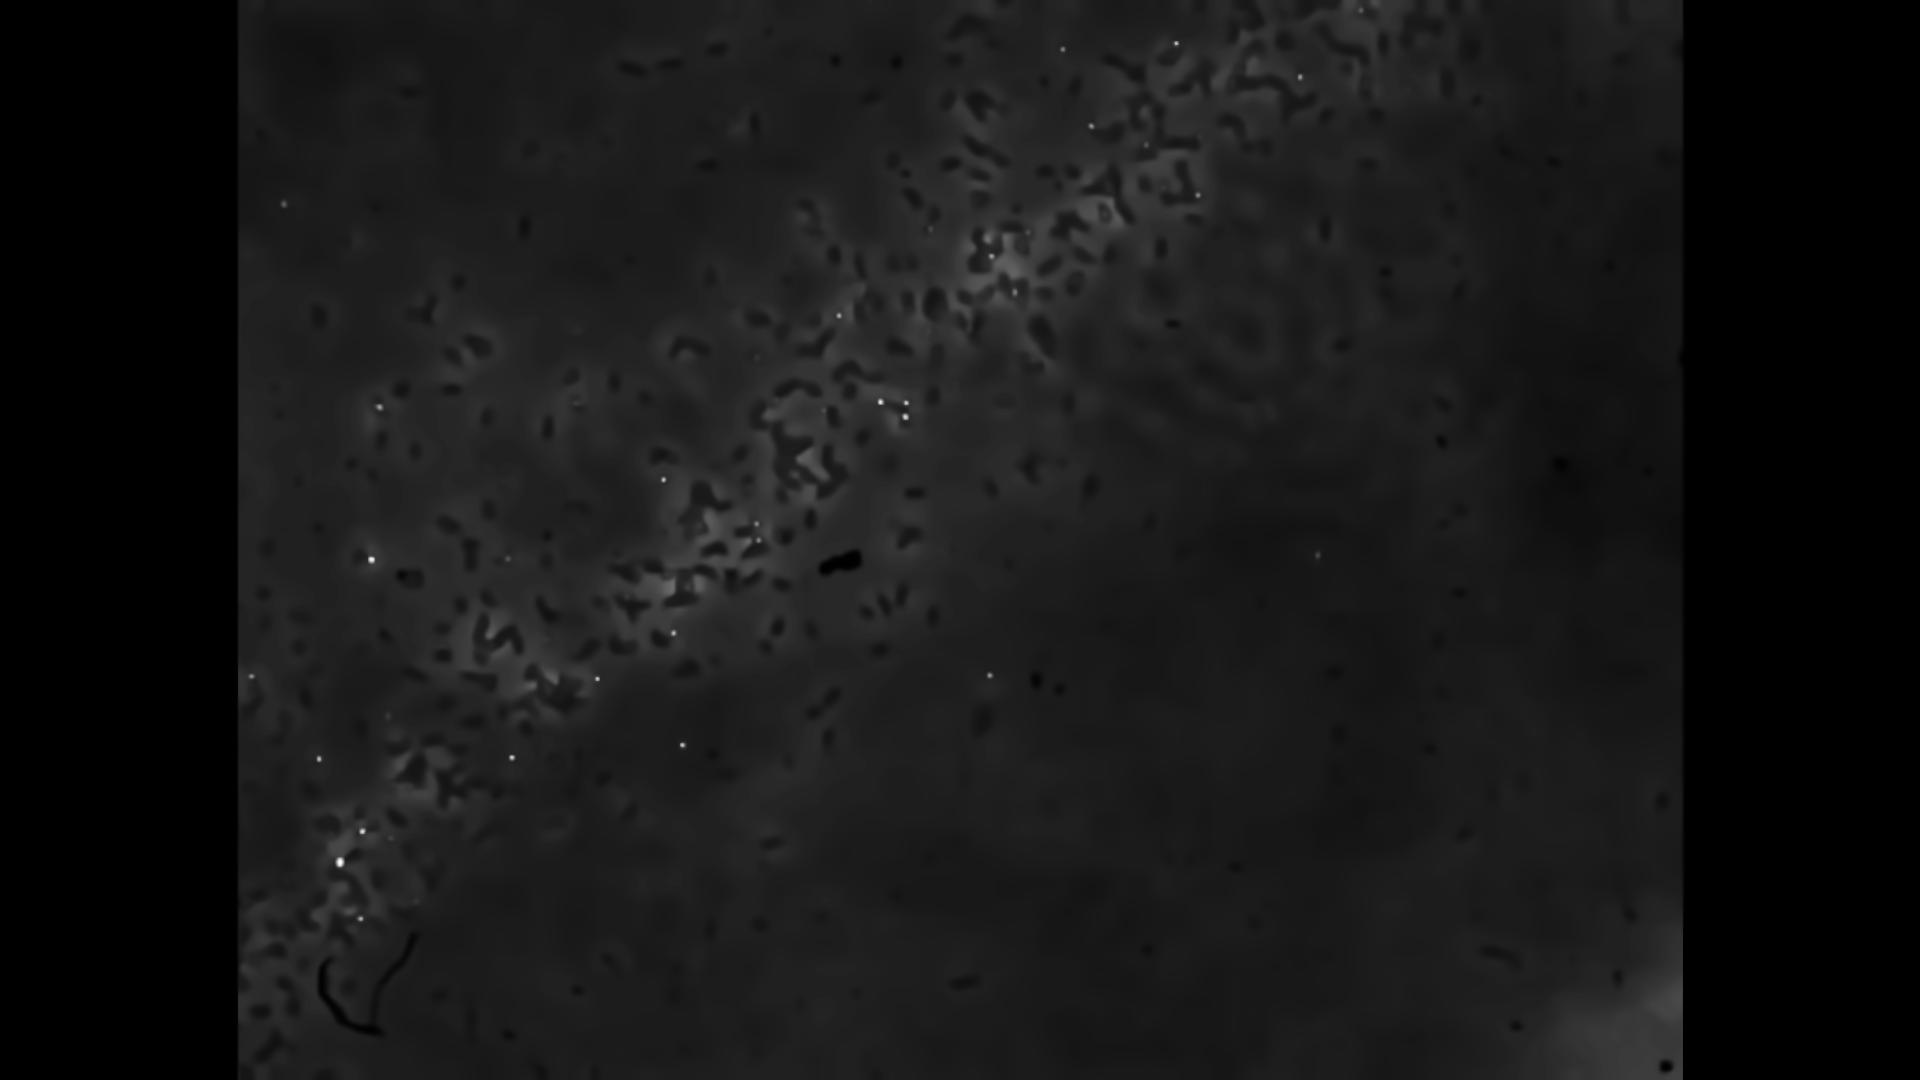